In [1]:
# import libraries
import os
import time
import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed
import tensorflow as tf
import logging
# tf.logging.set_verbosity(tf.logging.ERROR)

%load_ext autoreload
%autoreload 2
from fortadGAN.fortadGAN_utils import score_anomalies, reconstruction_errors
from fortadGAN.fortadGAN_layers import build_encoder_layer, build_generator_layer, build_critic_x_layer, build_critic_z_layer, wasserstein_loss
from fortadGAN.fortadGAN_preproc import time_segments_aggregate, rolling_window_sequences



from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers


# df.shape

In [2]:
seed(10)
# set_random_seed(10)

df = pd.read_csv('data/sensor.csv', index_col=0)
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,1522508400,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
1,1522508460,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,1522508520,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,1522508580,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,1522508640,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL


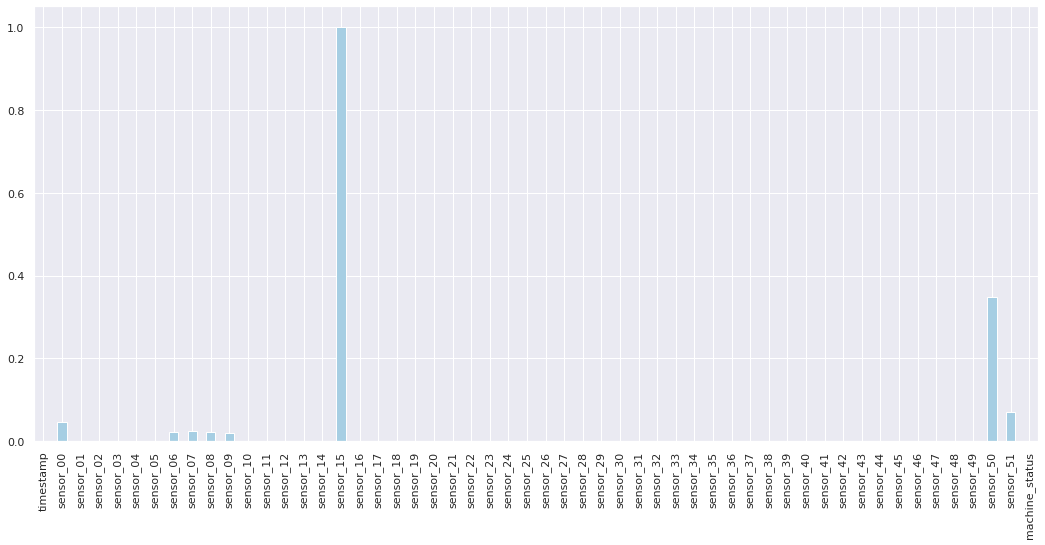

In [3]:
for var_index in [item for item in df.columns if 'sensor_' in item]:
    df[var_index] = pd.to_numeric(df[var_index], errors='coerce')

# ## 결측 변수 확인
(df.isnull().sum()/len(df)).plot.bar(figsize=(18, 8), colormap='Paired')

## 중복된 데이터를 삭제합니다.
df = df.drop_duplicates()
## 센서 15번, 센서 50 은 삭제합
del df['sensor_15']
del df['sensor_50']

## 이전 시점의 데이터로 보간
df = df.fillna(method='ffill')

# str으로 표현된 시간을 timestamp로 변환
df['timestamp'] = pd.to_datetime(df['timestamp'])
converted = list()
for t in df['timestamp']:
    timestamp = time.mktime(t.timetuple())
    converted.append(int(timestamp))

df['timestamp'] = converted

memory_df = df
df.head()

# 데이터 나눠서 적용하기 

    200만이 넘는 데이터이다 보니 적용하기 쉽지 않음
    3~4 구간으로 나눠사 학습 시킬 예정
    학습 결과를 따로 봐야 할듯함

In [4]:
len_df = len(df)
len_df_ec = len_df//4
df_1 = df[0:len_df_ec]
df_2 = df[len_df_ec:len_df_ec*2]
df_3 = df[len_df_ec*2:len_df_ec*3]
df_4 = df[len_df_ec*3:]

print(len(df_1),len(df_2),len(df_3),len(df_4))

55080 55080 55080 55080


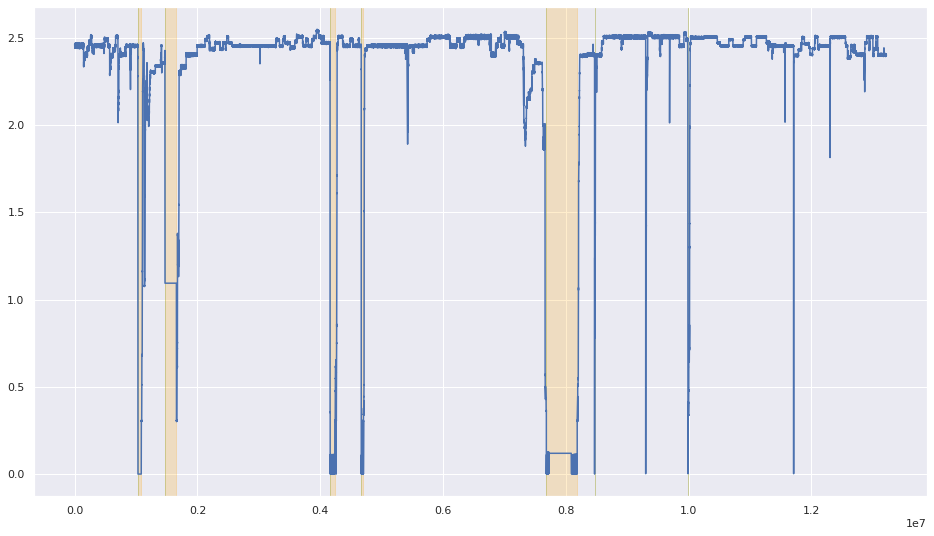

In [30]:
plt.figure(figsize=(16,9))
ax = plt.plot(times_n, df['sensor_00'])

# ax.size(16,9)
labels = df['machine_status'].values.tolist()
dates = df['timestamp'].values.tolist() -time_s.min()

# 고장구간 표시
temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == "BROKEN":
            plt.axvspan(temp_start, temp_date, alpha=0.2, color='green')
        if temp_label == "RECOVERING":
            plt.axvspan(temp_start, temp_date, alpha=0.2, color='orange')
        temp_start=xc
        temp_label=value
    temp_date = xc
if temp_label == "BROKEN":
    plt.axvspan(temp_start, xc, alpha=0.2, color='green')
if temp_label == "RECOVERING":
    plt.axvspan(temp_start, xc, alpha=0.2, color='orange')


In [32]:
len(dates)

220320

In [5]:

abnormal_df = df[df['machine_status']!='NORMAL']
# del abnormal_df['machine_status']
abnormal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 17155 to 166515
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       14484 non-null  int64  
 1   sensor_00       14484 non-null  float64
 2   sensor_01       14484 non-null  float64
 3   sensor_02       14484 non-null  float64
 4   sensor_03       14484 non-null  float64
 5   sensor_04       14484 non-null  float64
 6   sensor_05       14484 non-null  float64
 7   sensor_06       14484 non-null  float64
 8   sensor_07       14484 non-null  float64
 9   sensor_08       14484 non-null  float64
 10  sensor_09       14484 non-null  float64
 11  sensor_10       14484 non-null  float64
 12  sensor_11       14484 non-null  float64
 13  sensor_12       14484 non-null  float64
 14  sensor_13       14484 non-null  float64
 15  sensor_14       14484 non-null  float64
 16  sensor_16       14484 non-null  float64
 17  sensor_17       14484 non-

## 데이터 적용

    df_1 데이터만 가지고 일단 학습을 진행하도록 함
    추후에 다른 데이터 df_2, df_3, df_4를 어떻게 학습 시킬지는 고민해볼 예정

In [5]:
# 전처리 
X, index = time_segments_aggregate(df_1, interval=60, time_column='timestamp')
print(len(X))
print(len(index))
imp = SimpleImputer()
X = imp.fit_transform(X)
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X, y = rolling_window_sequences(X, index, 
                                window_size=100, 
                                target_size=1, 
                                step_size=1)
print("Training data input shape: {}".format(X.shape))
print("Training y shape: {}".format(y.shape))
# X, y, X_index, y_index = rolling_window_sequences(X, index, 
#                                                   window_size=100, 
#                                                   target_size=1, 
#                                                   step_size=1)
# print("Training data input shape: {}".format(X.shape))
# print("Training data index shape: {}".format(X_index.shape))
# print("Training y shape: {}".format(y.shape))
# print("Training y index shape: {}".format(y_index.shape))
LOGGER = logging.getLogger(__name__)


55080
55080
Training data input shape: (54981, 100, 50)
Training y shape: (54981,)


/home/rain/anaconda3/envs/tf2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [10]:
generator_input_shape[1]

50

In [6]:
channel_size = 50
window_size = 100
latent_dim = 20
shape = (window_size, channel_size)

# Train parameters
batch_size = 64
n_critics = 5
epochs = 10

# Layer Parameters
encoder_input_shape = (window_size, channel_size)
generator_input_shape = (20, channel_size)

critic_x_input_shape = (window_size, channel_size)
critic_z_input_shape = (20,channel_size)

encoder_reshape_shape = (20, channel_size)
generator_reshape_shape = (window_size//2, channel_size) # window_size//3 <- 3 is Upsampling size

learning_rate = 0.0005

# Build Model
encoder = build_encoder_layer(input_shape=encoder_input_shape,
                              encoder_reshape_shape=encoder_reshape_shape)

generator = build_generator_layer(input_shape=generator_input_shape,
                                  generator_reshape_shape=generator_reshape_shape)

critic_x = build_critic_x_layer(input_shape=critic_x_input_shape)
critic_z = build_critic_z_layer(input_shape=critic_z_input_shape)

encoder_optimizer = tf.keras.optimizers.Adam(learning_rate)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_x_optimizer = tf.keras.optimizers.Adam(learning_rate)
critic_z_optimizer = tf.keras.optimizers.Adam(learning_rate)

In [7]:
@tf.function
def critic_x_train_on_batch(x, z):
    # Loss 크게 이상 없음 
    with tf.GradientTape() as tape:
        x_ = generator(z)
        valid_x = critic_x(x)
        fake_x = critic_x(x_)
        
        # Interpolated 
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * x + (1 - alpha) * x_ 
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_x(interpolated)
        
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))
                
        loss1 = wasserstein_loss(-tf.ones_like(valid_x), valid_x)
        loss2 = wasserstein_loss(tf.ones_like(fake_x), fake_x)
        loss = loss1 + loss2 + gp_loss
                        
    gradients = tape.gradient(loss, critic_x.trainable_weights)
    critic_x_optimizer.apply_gradients(zip(gradients, critic_x.trainable_weights))
    return loss


@tf.function
def critic_z_train_on_batch(x, z):
    
    with tf.GradientTape() as tape:

        z_ = encoder(x)   
        valid_z = critic_z(z)             
        fake_z = critic_z(z_) # <- critic_z 의 결과가 매우 않음 
        
        # Interpolated 
        alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0)
        interpolated = alpha * z + (1 - alpha) * z_ 
                
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = critic_z(interpolated, training=True)
            
        grads = gp_tape.gradient(pred, interpolated)
        grad_norm = tf.norm(tf.reshape(grads, (batch_size, -1)), axis=1)
        gp_loss = 10.0*tf.reduce_mean(tf.square(grad_norm - 1.))
        
        loss1 = wasserstein_loss(-tf.ones_like(valid_z), valid_z)
        loss2 = wasserstein_loss(tf.ones_like(fake_z), fake_z) # <- 이게 미친듯이 뜀. 
        loss = loss1 + loss2 + gp_loss
        
    gradients = tape.gradient(loss, critic_z.trainable_weights)
    critic_z_optimizer.apply_gradients(zip(gradients, critic_z.trainable_weights))
    return loss


@tf.function
def enc_gen_train_on_batch(x, z):
    with tf.GradientTape() as enc_tape:
        
        z_gen_ = encoder(x, training=True)
        x_gen_ = generator(z, training=False)        
        x_gen_rec = generator(z_gen_, training=False)
        
        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)
        
        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        enc_loss = loss1 + loss2 + loss3
        
    gradients_encoder = enc_tape.gradient(enc_loss, encoder.trainable_weights)
    encoder_optimizer.apply_gradients(zip(gradients_encoder, encoder.trainable_weights))

    with tf.GradientTape() as gen_tape:
        
        z_gen_ = encoder(x, training=False)
        x_gen_ = generator(z, training=True)        
        x_gen_rec = generator(z_gen_, training=True)
        
        fake_gen_x = critic_x(x_gen_, training=False)
        fake_gen_z = critic_z(z_gen_, training=False)
        
        loss1 = wasserstein_loss(fake_gen_x, -tf.ones_like(fake_gen_x))
        loss2 = wasserstein_loss(fake_gen_z, -tf.ones_like(fake_gen_z))
        loss3 = 10.0*tf.reduce_mean(tf.keras.losses.MSE(x, x_gen_rec))

        gen_loss = loss1 + loss2 + loss3
        
    gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)    
    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_weights))    
    return enc_loss, gen_loss

In [8]:
tf.config.experimental_run_functions_eagerly(True)

X = X.reshape((-1, shape[0], channel_size))
X_ = np.copy(X)

In [9]:
epoch_e_loss = []    
epoch_g_loss = []
epoch_cx_loss = []
epoch_cz_loss = []

for epoch in range(1, epochs+1):
    
    np.random.shuffle(X_)
    
    minibatches_size = batch_size * n_critics  # 64*5 = 320 
    num_minibatches = int(X_.shape[0] // minibatches_size)  # 12 
    
    encoder.trainable = False
    generator.trainable = False
    
    for i in range(num_minibatches):
        minibatch = X_[i * minibatches_size: (i + 1) * minibatches_size]
        
        # Number of Critics 
        for j in range(n_critics):
            
            x = minibatch[j * batch_size: (j + 1) * batch_size]
            ## 임의의 신호를 만들어서 집어 넣어주는 단계 (GAN을 학습시키기 위해 존재함)
            z = tf.random.normal(shape=(batch_size, latent_dim, channel_size), mean=0.0, stddev=1, dtype=tf.dtypes.float32, seed=1748)

            
            critic_x.trainable = True
            critic_z.trainable = False
            epoch_cx_loss.append(critic_x_train_on_batch(x, z))
            critic_x.trainable = False
            critic_z.trainable = True
            epoch_cz_loss.append(critic_z_train_on_batch(x, z))
        
        critic_z.trainable = False
        critic_x.trainable = False
        encoder.trainable = True
        generator.trainable = True
        
        enc_loss, gen_loss = enc_gen_train_on_batch(x, z)
        epoch_e_loss.append(enc_loss)
        epoch_g_loss.append(gen_loss)
        
    cx_loss = np.mean(np.array(epoch_cx_loss), axis=0)
    cz_loss = np.mean(np.array(epoch_cz_loss), axis=0)
    e_loss = np.mean(np.array(epoch_e_loss), axis=0)
    g_loss = np.mean(np.array(epoch_g_loss), axis=0)
    
    print('Epoch: {}/{}, [Dx loss: {}] [Dz loss: {}] [E loss: {}] [G loss: {}]'.format(epoch, epochs, cx_loss, cz_loss, e_loss, g_loss))    

Epoch: 1/10, [Dx loss: -16.68679428100586] [Dz loss: -21.14148712158203] [E loss: 38.63529586791992] [G loss: 28.514991760253906]
Epoch: 2/10, [Dx loss: -11.521561622619629] [Dz loss: -11.621031761169434] [E loss: 17.272315979003906] [G loss: 11.973803520202637]
Epoch: 3/10, [Dx loss: -9.341485023498535] [Dz loss: -8.603657722473145] [E loss: 10.305325508117676] [G loss: 6.664742469787598]
Epoch: 4/10, [Dx loss: -8.016268730163574] [Dz loss: -7.264726161956787] [E loss: 5.984626770019531] [G loss: 3.201857089996338]
Epoch: 5/10, [Dx loss: -7.123964786529541] [Dz loss: -6.536059856414795] [E loss: 3.414846658706665] [G loss: 1.1449640989303589]
Epoch: 6/10, [Dx loss: -6.473843574523926] [Dz loss: -6.131491184234619] [E loss: 1.721907377243042] [G loss: -0.20594380795955658]
Epoch: 7/10, [Dx loss: -5.92154598236084] [Dz loss: -5.84491491317749] [E loss: 0.7466840147972107] [G loss: -0.9339368343353271]
Epoch: 8/10, [Dx loss: -5.483140468597412] [Dz loss: -5.834112644195557] [E loss: 0.52

In [10]:
encoder.save("model_encoder.h5")
generator.save("model_generator.h5")
critic_z.save("model_critic_z.h5")
critic_x.save("model_critic_x.h5")

In [15]:
def reconstruction(X):
    z_gen_ = encoder(X, training=False)
    x_gen_ = generator(z_gen_, training=False)
    X_critic = critic_x(x_gen_, training=False)
    return x_gen_, X_critic

X_gen, X_critic = reconstruction(X)

final_scores = score_anomalies(X, X_gen, X_critic, rec_error_type="dtw", comb="mult")

Error: Canceled future for execute_request message before replies were done

In [ ]:
# new_time = pd.to_datetime(df['timestamp'], format='%Y.%m.%d.%H.%M.%S')
# new_time

from datetime import datetime
def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

new_time = convert_date(df['timestamp'])
# new_time

In [ ]:
diff = np.mean(final_scores, axis=1)
scored = pd.DataFrame(index=new_time)
scored['Loss_mean']=diff
scored['loss_B1'] = final_scores[:,0]
scored['loss_B2'] = final_scores[:,1]
scored['loss_B3'] = final_scores[:,2]
scored['loss_B4'] = final_scores[:,3]

scored.plot(logy=True,  figsize=(16,9), ylim=[0,1e2], color=['blue','red', 'orange', 'green', 'magenta'])
plt.axvspan(train.index[0], train.index[-1], alpha=0.2)
plt.axvspan(test.index[0], test.index[-1], color='red', alpha=0.2)
